<a href="https://colab.research.google.com/github/noambassat/SupremeCourtClassifier/blob/main/6_1_both_models_retrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold,train_test_split,cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# from imblearn.under_sampling import RandomUnderSampler
from google.colab import drive


In [ ]:

# התחברות ל-Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
folder_id = "/בית המשפט - קבצים שנבדקו/full_data_BOTH_models_with_predictions.xlsx"

file_path = f"/content/drive/My Drive"
# /content/drive/MyDrive/full_rap_df_cleaned.xlsx

raap = pd.read_excel(file_path+"/full_rap_df_cleaned.xlsx")
data = pd.read_excel(file_path+folder_id)

/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


# EDA


In [ ]:
data.columns

Index(['level_0', 'index', 'גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך', 'גוף המסמך חתוך', 'predicted_probability',
       'prediction_original_model',
       'prediction_adjusted_threshold\nבקשת רשות ערעור התקבלה?',
       'גוף המסמך חתוך מסווג שני', 'prediction_second_model',
       'second_model_predicted_probability',
       'prediction_second_model_adjusted\nערעור התקבל?',
       'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
       'הערעור התקבל?', 'הערות תוצאת ערעור', 'רע"פ בקשה אחרת או דלמטה מיוחד',
       'קידוד', 'הערות '],
      dtype='object')

In [ ]:
data['רע"פ בקשה אחרת או דלמטה מיוחד'].value_counts()
data[(data['רע"פ בקשה אחרת או דלמטה מיוחד'] == 'בקשה אחרת') | (data['רע"פ בקשה אחרת או דלמטה מיוחד'] == 'דלמטה מיוחד')].shape[0]

65

In [ ]:
data = data[(data['רע"פ בקשה אחרת או דלמטה מיוחד'] != 'בקשה אחרת') & (data['רע"פ בקשה אחרת או דלמטה מיוחד'] != 'דלמטה מיוחד')]

In [ ]:
check_data = data[[
       'בקשה לרשות ערעור התקבלה?',
       'הערעור התקבל?']]

In [ ]:
check_data[check_data['בקשה לרשות ערעור התקבלה?'].isnull()]

,בקשה לרשות ערעור התקבלה?,הערעור התקבל?
8,NaN,NaN
13,NaN,NaN
21,NaN,NaN
22,NaN,NaN
27,NaN,NaN
...,...,...
2956,NaN,NaN
2957,NaN,NaN
2958,NaN,NaN
2959,NaN,NaN


In [ ]:
check_data[check_data[ 'הערעור התקבל?'].isnull()]

,בקשה לרשות ערעור התקבלה?,הערעור התקבל?
5,נדחה,NaN
6,נדחה,NaN
8,NaN,NaN
13,NaN,NaN
19,נדחה,NaN
...,...,...
2956,NaN,NaN
2957,NaN,NaN
2958,NaN,NaN
2959,NaN,NaN


In [ ]:
clean_data = data.dropna(subset = ['בקשה לרשות ערעור התקבלה?']).copy()

In [ ]:
# clean_data[['גוף המסמך', 'מספר הליך', 'שם הליך',
#        'שנת פתיחת ההליך', 'predicted_probability',
#        'prediction_original_model',
#        'prediction_adjusted_threshold\nבקשת רשות ערעור התקבלה?', 'prediction_second_model',
#        'second_model_predicted_probability',
#        'prediction_second_model_adjusted\nערעור התקבל?',
#        'בקשה לרשות ערעור התקבלה?',
#        'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
#        'הערעור התקבל?', 'הערות תוצאת ערעור', 'הערות ']]

In [ ]:
 clean_data['בקשה לרשות ערעור התקבלה?'].unique()

array(['התקבל', 'נדחה', 'חלקי', 'אחר'], dtype=object)

In [ ]:
clean_data["prediction_second_model_adjusted\nערעור התקבל?"].unique()

array([ 1.,  0., nan])

In [ ]:
clean_data = data[(data['בקשה לרשות ערעור התקבלה?'] != 'אחר')]

In [ ]:
clean_data.dropna(subset=["בקשה לרשות ערעור התקבלה?"],inplace=True)

<ipython-input-254-eb4b6f54d70e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data.dropna(subset=["בקשה לרשות ערעור התקבלה?"],inplace=True)


In [ ]:
clean_data['binary_outcome_for_first_classifier'] = clean_data['בקשה לרשות ערעור התקבלה?'].apply(lambda x: 0 if x == 'נדחה' else 1)

<ipython-input-255-c8b97bc14048>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['binary_outcome_for_first_classifier'] = clean_data['בקשה לרשות ערעור התקבלה?'].apply(lambda x: 0 if x == 'נדחה' else 1)


In [ ]:
clean_data['binary_outcome_for_first_classifier'].value_counts()

,count
binary_outcome_for_first_classifier,
1,85
0,77


In [ ]:
clean_data

,level_0,index,גוף המסמך,מספר הליך,שם הליך,שנת פתיחת ההליך,גוף המסמך חתוך,predicted_probability,prediction_original_model,prediction_adjusted_threshold\nבקשת רשות ערעור התקבלה?,...,second_model_predicted_probability,prediction_second_model_adjusted\nערעור התקבל?,בקשה לרשות ערעור התקבלה?,טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**),הערעור התקבל?,הערות תוצאת ערעור,"רע""פ בקשה אחרת או דלמטה מיוחד",קידוד,הערות,binary_outcome_for_first_classifier
1,152,152,"['פסק דין בתיק רע""פ 1917/18 בבית המשפט העליון ...","רע""פ 1917/18","רע""פ 1917/18 אחמד אבו סבית נ. מדינת ישראל",2018,"יה היעדר ההתייחסות לטענתו של המבקש, אשר נוגעת ...",0.824141,1,1,...,0.990648,1.0,התקבל,NaN,התקבל,"נו מקבלים את הערעור, כאמור במובן זה שהתיק יוחז...",NaN,גל,NaN,1
5,335,521,"['החלטה בתיק רע""פ 4873/14 בבית המשפט העליון רע...","רע""פ 4873/14","רע""פ 4873/14 מאיר פיסו נ. עופר אריאלי",2014,המטיל על הממרה קנס או מאסר. 5. בשולי הדברים א...,0.801372,1,1,...,0.665867,0.0,נדחה,"סבורני, כי אין מקום להיעתר לבקשה, מאחר שמדובר ...",NaN,NaN,NaN,גל,NaN,0
6,359,545,"['פסק דין בתיק רע""פ 3842/14 בבית המשפט העליון ...","רע""פ 3842/14","רע""פ 3842/14 מוחמד עלאוי נ. הוועדה המקומית לתכ...",2014,"ה: עו""ד עמית אופק פסק דין 1. בעקבות הערות בית ...",0.929815,1,1,...,0.990764,1.0,נדחה,נוכח האמור בפיסקה 1 שלעיל – בקשת רשות הערעור נ...,NaN,NaN,NaN,גל,NaN,0
7,362,548,"['פסק דין בתיק רע""פ 2875/14 בבית המשפט העליון ...","רע""פ 2875/14","רע""פ 2875/14 יואב קייסי נ. מדינת ישראל",2014,"ית ויעמוד על סך של 1,500 ש""ח. 2. נוכח ההודעה ש...",0.821090,1,1,...,0.998652,1.0,חלקי,בקשת הרשות לערער נענית רק לענין גובה הקנס.,חלקי,בקשת הרשות לערער נענית רק לענין גובה הקנס. הקנ...,NaN,גל,NaN,1
11,389,575,"['פסק דין בתיק רע""פ 3296/14 בבית המשפט העליון ...","רע""פ 3296/14","רע""פ 3296/14 מיתקאל עיאשי נ. עיאשי אחסאנ",2014,הרנו לצדדים. 2. על רקע עמדה זו ובהסכמת הצדדים ...,0.974469,1,1,...,0.999967,1.0,התקבל,NaN,התקבל,"פס""ד בעניין סמכות שיפוט מבוטל ולכן התיק מוחזר ...",NaN,גל,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2562,2984,4266,"['החלטה בתיק רע""פ 133/13 בבית המשפט העליון רע""...","רע""פ 133/13","רע""פ 133/13 ציקו עבדי נ. מדינת ישראל",2013,"הבלתי חוקיים באורך רוח ראוי לציון, ואולי הבעי...",0.201271,0,0,...,NaN,NaN,נדחה,NaN,NaN,NaN,NaN,דניאל,NaN,0
2581,3006,4288,"['החלטה בתיק רע""פ 182/13 בבית המשפט העליון רע""...","רע""פ 182/13","רע""פ 182/13 נעמ משה נ. מדינת ישראל",2013,"נית בגזר דינה, כהוא זה, מרף הענישה הראוי בנסיב...",0.047010,0,0,...,NaN,NaN,נדחה,NaN,NaN,NaN,NaN,דניאל,NaN,0
2699,3140,7361,"['החלטה בתיק רע""פ 1370/17 בבית המשפט העליון רע...","רע""פ 1370/17","רע""פ 1370/17",2017,"סר. 9. אשר על כן, בקשת רשות הערעור נדחית בזאת....",0.028190,0,0,...,NaN,NaN,נדחה,NaN,NaN,NaN,NaN,דניאל,NaN,0
2713,3154,7375,"['החלטה בתיק רע""פ 3183/17 בבית המשפט העליון רע...","רע""פ 3183/17","רע""פ 3183/17 יואל קרויז נ. מדינת ישראל",2017,"851/13 עודה נ\' מדינת ישראל (25.10.2015); ע""פ ...",0.112401,0,0,...,NaN,NaN,נדחה,NaN,NaN,NaN,NaN,דניאל,NaN,0


In [ ]:
clean_data.columns

Index(['level_0', 'index', 'גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך', 'גוף המסמך חתוך', 'predicted_probability',
       'prediction_original_model',
       'prediction_adjusted_threshold\nבקשת רשות ערעור התקבלה?',
       'גוף המסמך חתוך מסווג שני', 'prediction_second_model',
       'second_model_predicted_probability',
       'prediction_second_model_adjusted\nערעור התקבל?',
       'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
       'הערעור התקבל?', 'הערות תוצאת ערעור', 'רע"פ בקשה אחרת או דלמטה מיוחד',
       'קידוד', 'הערות ', 'binary_outcome_for_first_classifier'],
      dtype='object')

In [ ]:
clean_data["בקשה לרשות ערעור התקבלה?"].isnull().sum()

0

In [ ]:

def create_CM(data, labeled_col, predicted_col):
    # יצירת confusion matrix
    cm = confusion_matrix(data[labeled_col], data[predicted_col])

    # הצגת תוצאות confusion matrix
    print("Confusion Matrix:")
    print(cm)

    # ויזואליזציה של confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    if labeled_col.find("threshold") != -1:
        plt.title("Confusion Matrix for Threshold")
    plt.show()

    # חישוב Accuracy ו-F1 Score
    accuracy = accuracy_score(data[labeled_col], data[predicted_col])
    f1 = f1_score(data[labeled_col], data[predicted_col])

    # הצגת Accuracy ו-F1 Score
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")






In [ ]:
def create_CM_and_False_DF(data, predicted_col,labeled_col, probability_col):
    print("labeled_col: ", labeled_col,"predicted_col", predicted_col)
    """
    Creates a confusion matrix, calculates accuracy and F1 score, visualizes the matrix,
    and returns a DataFrame of errors (FN and FP).

    Parameters:
    - data (DataFrame): The DataFrame containing labeled, predicted, and probability columns.
    - labeled_col (str): Column name of the true labels.
    - predicted_col (str): Column name of the predicted labels.
    - probability_col (str): Column name of the prediction probabilities.

    Returns:
    - DataFrame: A DataFrame of errors (FN and FP) containing "מספר הליך", "גוף המסמך", "Error Type", and "Prediction Probability".
    """
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

    # יצירת confusion matrix
    cm = confusion_matrix(data[labeled_col], data[predicted_col])

    # הצגת תוצאות confusion matrix
    print("Confusion Matrix:")
    print(cm)

    # ויזואליזציה של confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # חישוב Accuracy ו-F1 Score
    accuracy = accuracy_score(data[labeled_col], data[predicted_col])
    f1 = f1_score(data[labeled_col], data[predicted_col])

    # הצגת Accuracy ו-F1 Score
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")

    # False Negatives: הערך בפועל 1 אך סווג כ-0
    fn_table = data[(data[labeled_col] == 1) & (data[predicted_col] == 0)][["מספר הליך", "גוף המסמך", probability_col]].copy()
    fn_table["Error Type"] = "FN"  # הוספת עמודת סוג הטעות

    # False Positives: הערך בפועל 0 אך סווג כ-1
    fp_table = data[(data[labeled_col] == 0) & (data[predicted_col] == 1)][["מספר הליך", "גוף המסמך", probability_col]].copy()
    fp_table["Error Type"] = "FP"  # הוספת עמודת סוג הטעות

    # איחוד הטבלאות
    errors_table = pd.concat([fn_table, fp_table], ignore_index=True)
    errors_table.rename(columns={probability_col: "Prediction Probability"}, inplace=True)

    # החזרת הטבלה
    return errors_table


In [ ]:
clean_data

,level_0,index,גוף המסמך,מספר הליך,שם הליך,שנת פתיחת ההליך,גוף המסמך חתוך,predicted_probability,prediction_original_model,prediction_adjusted_threshold\nבקשת רשות ערעור התקבלה?,...,second_model_predicted_probability,prediction_second_model_adjusted\nערעור התקבל?,בקשה לרשות ערעור התקבלה?,טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**),הערעור התקבל?,הערות תוצאת ערעור,"רע""פ בקשה אחרת או דלמטה מיוחד",קידוד,הערות,binary_outcome_for_first_classifier
1,152,152,"['פסק דין בתיק רע""פ 1917/18 בבית המשפט העליון ...","רע""פ 1917/18","רע""פ 1917/18 אחמד אבו סבית נ. מדינת ישראל",2018,"יה היעדר ההתייחסות לטענתו של המבקש, אשר נוגעת ...",0.824141,1,1,...,0.990648,1.0,התקבל,NaN,התקבל,"נו מקבלים את הערעור, כאמור במובן זה שהתיק יוחז...",NaN,גל,NaN,1
5,335,521,"['החלטה בתיק רע""פ 4873/14 בבית המשפט העליון רע...","רע""פ 4873/14","רע""פ 4873/14 מאיר פיסו נ. עופר אריאלי",2014,המטיל על הממרה קנס או מאסר. 5. בשולי הדברים א...,0.801372,1,1,...,0.665867,0.0,נדחה,"סבורני, כי אין מקום להיעתר לבקשה, מאחר שמדובר ...",NaN,NaN,NaN,גל,NaN,0
6,359,545,"['פסק דין בתיק רע""פ 3842/14 בבית המשפט העליון ...","רע""פ 3842/14","רע""פ 3842/14 מוחמד עלאוי נ. הוועדה המקומית לתכ...",2014,"ה: עו""ד עמית אופק פסק דין 1. בעקבות הערות בית ...",0.929815,1,1,...,0.990764,1.0,נדחה,נוכח האמור בפיסקה 1 שלעיל – בקשת רשות הערעור נ...,NaN,NaN,NaN,גל,NaN,0
7,362,548,"['פסק דין בתיק רע""פ 2875/14 בבית המשפט העליון ...","רע""פ 2875/14","רע""פ 2875/14 יואב קייסי נ. מדינת ישראל",2014,"ית ויעמוד על סך של 1,500 ש""ח. 2. נוכח ההודעה ש...",0.821090,1,1,...,0.998652,1.0,חלקי,בקשת הרשות לערער נענית רק לענין גובה הקנס.,חלקי,בקשת הרשות לערער נענית רק לענין גובה הקנס. הקנ...,NaN,גל,NaN,1
11,389,575,"['פסק דין בתיק רע""פ 3296/14 בבית המשפט העליון ...","רע""פ 3296/14","רע""פ 3296/14 מיתקאל עיאשי נ. עיאשי אחסאנ",2014,הרנו לצדדים. 2. על רקע עמדה זו ובהסכמת הצדדים ...,0.974469,1,1,...,0.999967,1.0,התקבל,NaN,התקבל,"פס""ד בעניין סמכות שיפוט מבוטל ולכן התיק מוחזר ...",NaN,גל,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2562,2984,4266,"['החלטה בתיק רע""פ 133/13 בבית המשפט העליון רע""...","רע""פ 133/13","רע""פ 133/13 ציקו עבדי נ. מדינת ישראל",2013,"הבלתי חוקיים באורך רוח ראוי לציון, ואולי הבעי...",0.201271,0,0,...,NaN,NaN,נדחה,NaN,NaN,NaN,NaN,דניאל,NaN,0
2581,3006,4288,"['החלטה בתיק רע""פ 182/13 בבית המשפט העליון רע""...","רע""פ 182/13","רע""פ 182/13 נעמ משה נ. מדינת ישראל",2013,"נית בגזר דינה, כהוא זה, מרף הענישה הראוי בנסיב...",0.047010,0,0,...,NaN,NaN,נדחה,NaN,NaN,NaN,NaN,דניאל,NaN,0
2699,3140,7361,"['החלטה בתיק רע""פ 1370/17 בבית המשפט העליון רע...","רע""פ 1370/17","רע""פ 1370/17",2017,"סר. 9. אשר על כן, בקשת רשות הערעור נדחית בזאת....",0.028190,0,0,...,NaN,NaN,נדחה,NaN,NaN,NaN,NaN,דניאל,NaN,0
2713,3154,7375,"['החלטה בתיק רע""פ 3183/17 בבית המשפט העליון רע...","רע""פ 3183/17","רע""פ 3183/17 יואל קרויז נ. מדינת ישראל",2017,"851/13 עודה נ\' מדינת ישראל (25.10.2015); ע""פ ...",0.112401,0,0,...,NaN,NaN,נדחה,NaN,NaN,NaN,NaN,דניאל,NaN,0


labeled_col:  binary_outcome_for_first_classifier predicted_col prediction_adjusted_threshold
בקשת רשות ערעור התקבלה?
Confusion Matrix:
[[52 25]
 [ 2 83]]


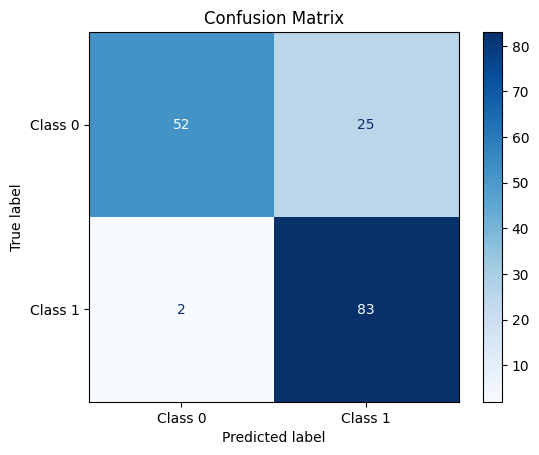

Accuracy: 0.83
F1 Score: 0.86


In [ ]:
first_classifier_False = create_CM_and_False_DF(clean_data,"prediction_adjusted_threshold\nבקשת רשות ערעור התקבלה?",'binary_outcome_for_first_classifier',"predicted_probability")

In [ ]:
first_classifier_False

,מספר הליך,גוף המסמך,Prediction Probability,Error Type
0,"רע""פ 4753/08","['פסק דין בתיק רע""פ 4753/08 בבית המשפט העליון ...",0.592379,FN
1,"רע""פ 7888/13","['החלטה בתיק רע""פ 7888/13 בבית המשפט העליון רע...",0.253042,FN
2,"רע""פ 4873/14","['החלטה בתיק רע""פ 4873/14 בבית המשפט העליון רע...",0.801372,FP
3,"רע""פ 3842/14","['פסק דין בתיק רע""פ 3842/14 בבית המשפט העליון ...",0.929815,FP
4,"רע""פ 7171/14","['פסק דין בתיק רע""פ 7171/14 בבית המשפט העליון ...",0.927490,FP
5,"רע""פ 8370/14","['פסק דין בתיק רע""פ 8370/14 בבית המשפט העליון ...",0.836758,FP
6,"רע""פ 8277/03","['פסק-דין בתיק רע""פ 8277/03 בבית המשפט העליון ...",0.835363,FP
7,"רע""פ 6585/12","['החלטה בתיק רע""פ 6585/12 בבית המשפט העליון רע...",0.891004,FP
8,"רע""פ 84/12","['החלטה בתיק רע""פ 84/12 בבית המשפט העליון רע""פ...",0.809881,FP
9,"רע""פ 2434/12","['פסק דין בתיק רע""פ 2434/12 בבית המשפט העליון ...",0.954118,FP


In [ ]:
first_classifier_False

,מספר הליך,גוף המסמך,Prediction Probability,Error Type
0,"רע""פ 4753/08","['פסק דין בתיק רע""פ 4753/08 בבית המשפט העליון ...",0.592379,FN
1,"רע""פ 7888/13","['החלטה בתיק רע""פ 7888/13 בבית המשפט העליון רע...",0.253042,FN
2,"רע""פ 4873/14","['החלטה בתיק רע""פ 4873/14 בבית המשפט העליון רע...",0.801372,FP
3,"רע""פ 3842/14","['פסק דין בתיק רע""פ 3842/14 בבית המשפט העליון ...",0.929815,FP
4,"רע""פ 7171/14","['פסק דין בתיק רע""פ 7171/14 בבית המשפט העליון ...",0.927490,FP
5,"רע""פ 8370/14","['פסק דין בתיק רע""פ 8370/14 בבית המשפט העליון ...",0.836758,FP
6,"רע""פ 8277/03","['פסק-דין בתיק רע""פ 8277/03 בבית המשפט העליון ...",0.835363,FP
7,"רע""פ 6585/12","['החלטה בתיק רע""פ 6585/12 בבית המשפט העליון רע...",0.891004,FP
8,"רע""פ 84/12","['החלטה בתיק רע""פ 84/12 בבית המשפט העליון רע""פ...",0.809881,FP
9,"רע""פ 2434/12","['פסק דין בתיק רע""פ 2434/12 בבית המשפט העליון ...",0.954118,FP


## First classifier

Confusion Matrix:
[[52  2]
 [25 83]]


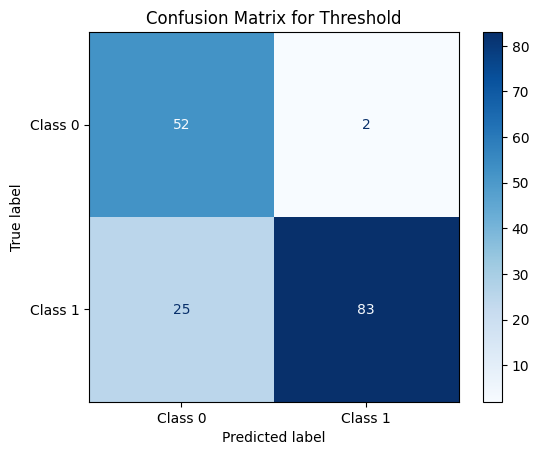

Accuracy: 0.83
F1 Score: 0.86


In [ ]:
create_CM(clean_data,"prediction_adjusted_threshold\nבקשת רשות ערעור התקבלה?",'binary_outcome_for_first_classifier')

Confusion Matrix:
[[47  1]
 [30 84]]


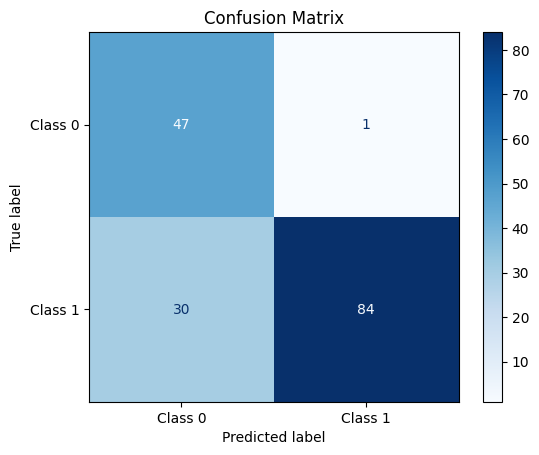

Accuracy: 0.81
F1 Score: 0.84


In [ ]:
create_CM(clean_data,"prediction_original_model",'binary_outcome_for_first_classifier')


In [ ]:
clean_data['binary_outcome_for_second_classifier'] = clean_data['הערעור התקבל?'].apply(lambda x: 0 if x == 'נדחה' else 1)

<ipython-input-268-639cee1ac157>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['binary_outcome_for_second_classifier'] = clean_data['הערעור התקבל?'].apply(lambda x: 0 if x == 'נדחה' else 1)


In [ ]:
y_probs = "predicted_probability"
y_pred_col = "prediction_original_model"
y_true_col = "binary_outcome_for_first_classifier"

### ניתוח הגרפים והסקת מסקנות תוך התחשבות במציאות האמיתית

#### **1. Sigmoid Curve**
הגרף של הסיגמואיד מדגים את פיזור הנתונים עבור עקומת המודל, כאשר בבדיקות הנוכחיות (דאטה מאוזן יחסית), יש ייצוג דומה לשתי המחלקות (0 ו-1). עם זאת, במציאות האמיתית, בה רוב הדגימות שייכות למחלקה 0 (מעל 90%), קיים סיכוי גבוה לטעויות מסוג False Positives (FP). לכן, בחירת Threshold גבוה יותר עשויה להיות עדיפה בעולם האמיתי, כדי לצמצם טעויות FP על חשבון ירידה מסוימת ב-TPR (True Positive Rate).

---

#### **2. ROC Curve**
ה-ROC Curve מספק מדד מצוין לביצועי המודל, ומראה ששטח ה-AUC (Area Under Curve) הוא 0.87, מה שמעיד על הפרדה טובה בין המחלקות. ה-Optimal Threshold המוצע בגרף הוא 0.75, שמאזן היטב בין TPR ל-FPR בדאטה המאוזן. יחד עם זאת, בעולם האמיתי, רוב הדגימות שייכות למחלקה 0, ולכן Threshold זה עשוי לספק איזון טוב לצמצום FP, אך עלול להוביל לעלייה ב-FN (False Negatives).

---

#### **3. Cost Function**
בגרף ה-Cost Function ניתן לראות ש-Threshold של 0.5 הוא האופטימלי מבחינת עלות עבור הדאטה המאוזן. עם זאת, במציאות שבה רוב הדגימות שייכות למחלקה 0, העלות של FN (החמצת מקרים קריטיים של מחלקה 1) עשויה להיות משמעותית מאוד. לפיכך, Threshold נמוך יותר מ-0.75 אך גבוה מ-0.5, למשל 0.67, יכול להוות פשרה טובה שמאזנת בין צמצום FP לבין שמירה על Recall גבוה עבור מחלקה 1.

---

#### **החלטה על Threshold מותאם לעולם האמיתי**
בהתחשב בניתוח הגרפים והמציאות האמיתית שבה הדאטה אינו מאוזן (עם רוב של מעל 90% למחלקה 0):
1. **Threshold של 0.67** נבחר כפשרה בין הגרפים השונים:
   - הוא מספיק גבוה כדי לצמצם FP.
   - שומר על Recall סביר, החשוב לאיתור נכון של מחלקה 1.
2. Threshold זה מתאים לשימוש גם על הדאטה המאוזן וגם על המציאות האמיתית, שבה עלות של FN היא גבוהה במיוחד.

---

#### **המלצות להמשך**
1. לבדוק את הביצועים של המודל עם Threshold של 0.67 על דאטה המדמה את המציאות האמיתית (עם רוב של מחלקה 0).
2. לעדכן את Cost Function ואת ה-Precision-Recall Curve במקרה של שינוי בתנאי העלות או בנתוני המציאות.

---

#### **סיכום**
Threshold של 0.67 מהווה פשרה חכמה ומעשית בהתחשב בדאטה המאוזן בבדיקות ובמציאות האמיתית של הדומיננטיות של מחלקה 0. הבחירה תאפשר איזון מיטבי בין צמצום FP לשימור Recall גבוה.


## Second classifier

In [ ]:
check_data = clean_data.dropna(subset=["הערעור התקבל?"])
check_data[check_data["prediction_second_model_adjusted\nערעור התקבל?"].isna()]

,level_0,index,גוף המסמך,מספר הליך,שם הליך,שנת פתיחת ההליך,גוף המסמך חתוך,predicted_probability,prediction_original_model,prediction_adjusted_threshold\nבקשת רשות ערעור התקבלה?,...,prediction_second_model_adjusted\nערעור התקבל?,בקשה לרשות ערעור התקבלה?,טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**),הערעור התקבל?,הערות תוצאת ערעור,"רע""פ בקשה אחרת או דלמטה מיוחד",קידוד,הערות,binary_outcome_for_first_classifier,binary_outcome_for_second_classifier
1346,1674,2618,"['פסק דין בתיק רע""פ 4753/08 בבית המשפט העליון ...","רע""פ 4753/08","רע""פ 4753/08 דמיטרי סנקובסקי נ. מדינת ישראל",2008,אנו מחליטים כדלקמן: בקשת רשות הערעור של המבקש...,0.592379,1,0,...,NaN,התקבל,"בקשת רשות הערעור של המבקש מתקבלת,",התקבל,"בקשת רשות הערעור של המבקש מתקבלת, וההחלטה המשל...",NaN,גל,NaN,1,1
2471,2886,4168,"['החלטה בתיק רע""פ 7888/13 בבית המשפט העליון רע...","רע""פ 7888/13","רע""פ 7888/13 עודד נחומ נ. מדינת ישראל",2013,"קירה, ונסמכת בעיקרה על מסכת העובדות מכתב האישו...",0.253042,0,0,...,NaN,התקבל,החלטנו לתת רשות ערעור כמבוקש ולדון בבקשה כבערע...,חלקי,במובן זה שאנו מזכים את המבקש מעבירת שיבוש מהלכ...,NaN,דניאל,NaN,1,1


In [ ]:
check_data['הערעור התקבל?'].unique()

array(['התקבל', 'חלקי', 'נדחה', 'אחר'], dtype=object)

In [ ]:
check_data[check_data['הערעור התקבל?']=="אחר"]

,level_0,index,גוף המסמך,מספר הליך,שם הליך,שנת פתיחת ההליך,גוף המסמך חתוך,predicted_probability,prediction_original_model,prediction_adjusted_threshold\nבקשת רשות ערעור התקבלה?,...,prediction_second_model_adjusted\nערעור התקבל?,בקשה לרשות ערעור התקבלה?,טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**),הערעור התקבל?,הערות תוצאת ערעור,"רע""פ בקשה אחרת או דלמטה מיוחד",קידוד,הערות,binary_outcome_for_first_classifier,binary_outcome_for_second_classifier
113,2084,3029,"['פסק דין בתיק רע""פ 4679/08 בבית המשפט העליון ...","רע""פ 4679/08","רע""פ 4679/08 חיימ לוי נ. מדינת ישראל",2008,נוצרה אי בהירות ביחס לדרך יישומו של פסק הדין כ...,0.941350,1,1,...,1.0,התקבל,NaN,אחר,"נוכח השגגה שיצאה מתחת ידו של בית המשפט קמא, אנ...",NaN,גל,NaN,1,1
118,2143,3088,"['פסק דין בתיק רע""פ 5921/08 בבית המשפט העליון ...","רע""פ 5921/08","רע""פ 5921/08 רביע רג'בי נ. מדינת ישראל",2008,יעמדו בעינם. ההחלטה לעיכוב ביצוע עונש המאסר מי...,0.885901,1,1,...,1.0,חלקי,החלטנו להיעתר לבקשה לרשות ערעור ולראותה כאילו ...,אחר,"ראינו לנכון להקל במעט בעונש שהושת עליו, כך שא...",NaN,גל,NaN,1,1
129,2281,3563,"['פסק דין בתיק רע""פ 1793/09 בבית המשפט העליון ...","רע""פ 1793/09","רע""פ 1793/09 פאבל מינסטר נ. מדינת ישראל",2009,"נשיא השופט ז\' המר, ס. הנשיא השופטת ב\' אופיר-...",0.917877,1,1,...,0.0,התקבל,NaN,אחר,NaN,NaN,דניאל,ביהמש לא הכריע בערעור והחזיר לדיון נוסף במחוזי,1,1
131,2285,3567,"['פסק דין בתיק רע""פ 5066/09 בבית המשפט העליון ...","רע""פ 5066/09","רע""פ 5066/09 ירונ אוחיונ נ. מדינת ישראל",2009,"במקומו. ב. ולבסוף, אצטרף לדברי חברי בסיפת דברי...",0.953114,1,1,...,0.0,התקבל,NaN,אחר,אין מידע על תוצאות הערעור,NaN,דניאל,NaN,1,1
180,2985,4267,"['פסק דין בתיק רע""פ 4384/13 בבית המשפט העליון ...","רע""פ 4384/13","רע""פ 4384/13 מדינת ישראל נ. מיאו והאו בע""מ",2013,"ם, ככל שהמשיבים יורשעו בדין. נוכח לוח הזמנים ה...",0.976018,1,1,...,1.0,התקבל,NaN,אחר,עניינם של המבקשים יובא בשנית בפני בית המשפט המ...,NaN,דניאל,NaN,1,1
183,3032,4314,"['פסק דין בתיק רע""פ 655/13 בבית המשפט העליון ר...","רע""פ 655/13","רע""פ 655/13 ראובנ יאיר נ. מדינת ישראל",2013,ד אופיר טישלר פסק דין משלים בהמשך לפסק דיננו מ...,0.797494,1,1,...,1.0,התקבל,NaN,אחר,"בהמשך לפסק דיננו מיום 4.3.2013, הננו קובעים כי...",NaN,דניאל,אין מספיק מידע על בקשת הערעור כדי לקבוע האם הת...,1,1


In [ ]:
check_data.columns

Index(['level_0', 'index', 'גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך', 'גוף המסמך חתוך', 'predicted_probability',
       'prediction_original_model',
       'prediction_adjusted_threshold\nבקשת רשות ערעור התקבלה?',
       'גוף המסמך חתוך מסווג שני', 'prediction_second_model',
       'second_model_predicted_probability',
       'prediction_second_model_adjusted\nערעור התקבל?',
       'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
       'הערעור התקבל?', 'הערות תוצאת ערעור', 'רע"פ בקשה אחרת או דלמטה מיוחד',
       'קידוד', 'הערות ', 'binary_outcome_for_first_classifier',
       'binary_outcome_for_second_classifier'],
      dtype='object')

In [ ]:
check_data = check_data[check_data['הערעור התקבל?']!="אחר"]

In [ ]:
check_data['הערעור התקבל?'].unique()

array(['התקבל', 'חלקי', 'נדחה'], dtype=object)

In [ ]:
check_data['binary_outcome_for_second_classifier'] = clean_data['הערעור התקבל?'].apply(lambda x: 0 if x == 'נדחה' else 1)

<ipython-input-276-f7b8d880d0b8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_data['binary_outcome_for_second_classifier'] = clean_data['הערעור התקבל?'].apply(lambda x: 0 if x == 'נדחה' else 1)


In [ ]:
check_data["prediction_second_model_adjusted\nערעור התקבל?"].isna().sum()

2

In [ ]:
check_data.dropna(subset=["prediction_second_model_adjusted\nערעור התקבל?"],inplace = True)

<ipython-input-278-511ac2cde83d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_data.dropna(subset=["prediction_second_model_adjusted\nערעור התקבל?"],inplace = True)


In [ ]:
check_data.dropna(subset=["prediction_second_model_adjusted\nערעור התקבל?"],inplace=True)

<ipython-input-279-1a055c041c5e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_data.dropna(subset=["prediction_second_model_adjusted\nערעור התקבל?"],inplace=True)


Confusion Matrix:
[[ 5  8]
 [ 4 63]]


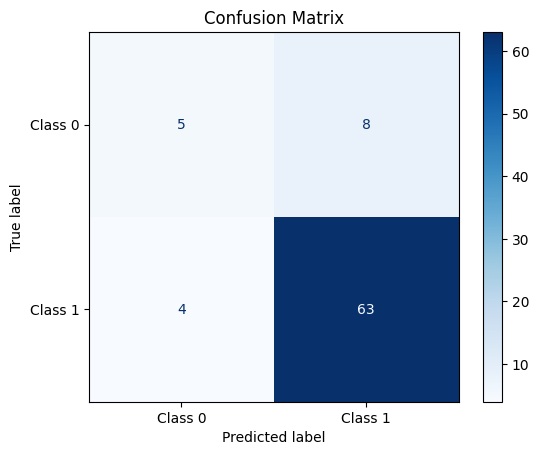

Accuracy: 0.85
F1 Score: 0.91


In [ ]:
create_CM(check_data,'prediction_second_model_adjusted\nערעור התקבל?','binary_outcome_for_second_classifier')

Confusion Matrix:
[[ 0  1]
 [ 9 70]]


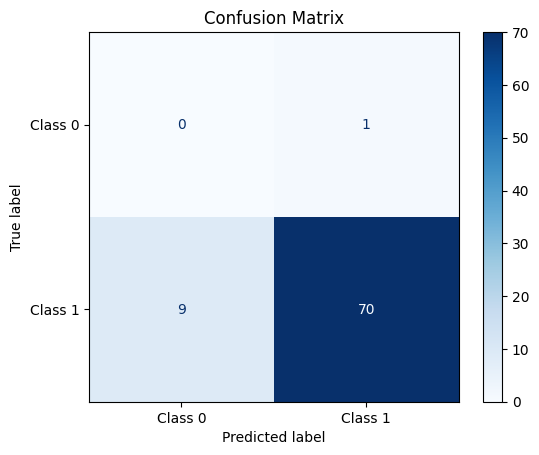

Accuracy: 0.88
F1 Score: 0.93


In [ ]:
create_CM(check_data,"prediction_second_model",'binary_outcome_for_second_classifier')

Confusion Matrix:
[[ 5  5]
 [ 4 66]]


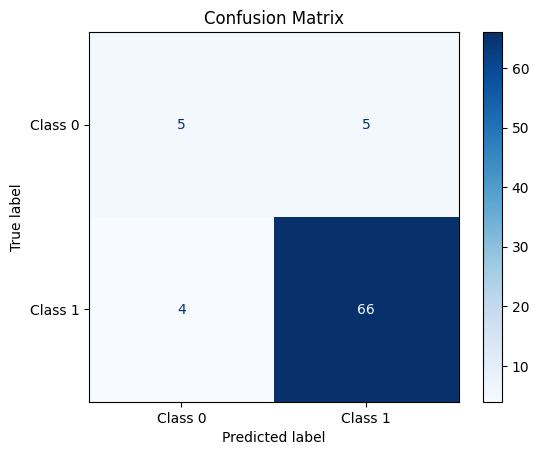

Accuracy: 0.89
F1 Score: 0.94


In [ ]:
check_data["new_prediction_col"] = [1 if x > 0.9 else 0 for x in check_data["second_model_predicted_probability"]]

create_CM(check_data,"new_prediction_col",'binary_outcome_for_second_classifier')

#0.89

labeled_col:  binary_outcome_for_second_classifier predicted_col new_prediction_col
Confusion Matrix:
[[ 5  4]
 [ 5 66]]


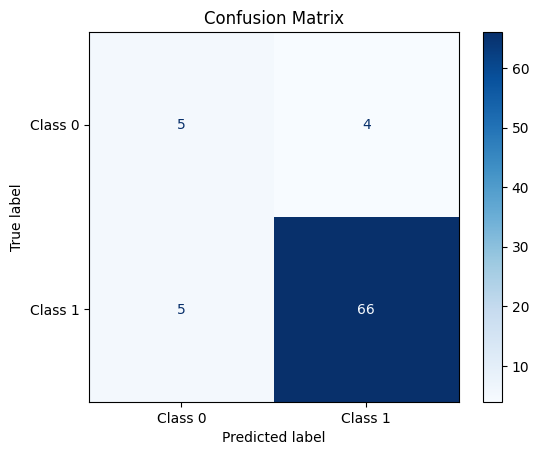

Accuracy: 0.89
F1 Score: 0.94


In [ ]:
second_classifier_False = create_CM_and_False_DF(check_data,"new_prediction_col",'binary_outcome_for_second_classifier',"second_model_predicted_probability")

In [ ]:
second_classifier_False

,מספר הליך,גוף המסמך,Prediction Probability,Error Type
0,"רע""פ 8917/03","['פסק-דין בתיק רע""פ 8917/03 בבית המשפט העליון ...",0.879912,FN
1,"רע""פ 10857/08","['פסק דין בתיק רע""פ 10857/08 בבית המשפט העליון...",0.560821,FN
2,"רע""פ 5123/08","['החלטה בתיק רע""פ 5123/08 בבית המשפט העליון רע...",0.389655,FN
3,"רע""פ 5740/08","['פסק דין בתיק רע""פ 5740/08 בבית המשפט העליון ...",0.813110,FN
4,"רע""פ 7480/09","['החלטה בתיק רע""פ 7480/09 בבית המשפט העליון רע...",0.506588,FN
5,"רע""פ 84/12","['החלטה בתיק רע""פ 84/12 בבית המשפט העליון רע""פ...",0.982077,FP
6,"רע""פ 2889/08","['פסק דין בתיק רע""פ 2889/08 בבית המשפט העליון ...",0.992407,FP
7,"רע""פ 8645/09","['פסק דין בתיק רע""פ 8645/09 בבית המשפט העליון ...",0.998132,FP
8,"רע""פ 2996/13","['פסק דין בתיק רע""פ 2996/13 בבית המשפט העליון ...",0.969103,FP


In [ ]:
false_classification = pd.merge(
    first_classifier_False,
    second_classifier_False,
    how="outer",
    on="מספר הליך",
    suffixes=('_first', '_second')  # סיומות רק לעמודות שונות
)

# שילוב עמודת "גוף המסמך" משני ה-DataFrames לעמודה אחת
if "גוף המסמך_first" in false_classification.columns and "גוף המסמך_second" in false_classification.columns:
    false_classification["גוף המסמך"] = false_classification["גוף המסמך_first"].combine_first(false_classification["גוף המסמך_second"])
    false_classification.drop(columns=["גוף המסמך_first", "גוף המסמך_second"], inplace=True)


In [ ]:
false_classification

,מספר הליך,Prediction Probability_first,Error Type_first,Prediction Probability_second,Error Type_second,גוף המסמך
0,"רע""פ 10857/08",NaN,NaN,0.560821,FN,"['פסק דין בתיק רע""פ 10857/08 בבית המשפט העליון..."
1,"רע""פ 1276/13",0.747414,FP,NaN,NaN,"['החלטה בתיק רע""פ 1276/13 בבית המשפט העליון רע..."
2,"רע""פ 151/12",0.909130,FP,NaN,NaN,"['פסק דין בתיק רע""פ 151/12 בבית המשפט העליון ר..."
3,"רע""פ 1840/12",0.748180,FP,NaN,NaN,"['החלטה בתיק רע""פ 1840/12 בבית המשפט העליון רע..."
4,"רע""פ 1995/17",0.806042,FP,NaN,NaN,"['החלטה בתיק רע""פ 1995/17 בבית המשפט העליון רע..."
5,"רע""פ 2434/12",0.954118,FP,NaN,NaN,"['פסק דין בתיק רע""פ 2434/12 בבית המשפט העליון ..."
6,"רע""פ 2675/13",0.830653,FP,NaN,NaN,"['פסק דין בתיק רע""פ 2675/13 בבית המשפט העליון ..."
7,"רע""פ 2682/08",0.876751,FP,NaN,NaN,"['החלטה בתיק רע""פ 2682/08 בבית המשפט העליון רע..."
8,"רע""פ 2765/13",0.676055,FP,NaN,NaN,"['החלטה בתיק רע""פ 2765/13 בבית המשפט העליון רע..."
9,"רע""פ 2851/08",0.911127,FP,NaN,NaN,"['החלטה בתיק רע""פ 2851/08 בבית המשפט העליון רע..."


In [ ]:
output_file = "/content/drive/My Drive/False_classification_report.xlsx"  # עדכן את הנתיב לשמירת הקובץ
false_classification.to_excel(output_file, index=False)
print(f"Combined file saved at: {output_file}")

Combined file saved at: /content/drive/My Drive/False_classification_report.xlsx


Conclusion

first classifier treshold for predction: 0.67
second classifier treshold for prediction: 0.9


# Re training

## First classifier

  

In [ ]:
data = clean_data[["גוף המסמך חתוך","binary_outcome_for_first_classifier"]]

# Index(['level_0', 'index', 'גוף המסמך', 'מספר הליך', 'שם הליך',
#        'שנת פתיחת ההליך', 'גוף המסמך חתוך', 'predicted_probability',
#        'prediction_original_model',
#        'prediction_adjusted_threshold\nבקשת רשות ערעור התקבלה?',
#        'גוף המסמך חתוך מסווג שני', 'prediction_second_model',
#        'second_model_predicted_probability',
#        'prediction_second_model_adjusted\nערעור התקבל?',
#        'בקשה לרשות ערעור התקבלה?',
#        'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
#        'הערעור התקבל?', 'הערות תוצאת ערעור', 'רע"פ בקשה אחרת או דלמטה מיוחד',
#        'קידוד', 'הערות '],
#       dtype='object')

In [ ]:
from transformers import AutoTokenizer, AutoModel
import numpy as np
import joblib
import pandas as pd

# טעינת המודל והטוקנייזר
tokenizer = AutoTokenizer.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")
model = AutoModel.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")

# פונקציה שמקבלת טקסט ומחזירה את האימבדינג כוקטור
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings[0]

### Embedding

In [ ]:
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_predict, cross_validate
import joblib


# עדכון עמודת המטרה ואימבדינג לאחר חיתוך הטקסטים
y = data["binary_outcome_for_first_classifier"].values
embeddings = np.array([get_embeddings(text) for text in data["גוף המסמך חתוך"]])


### Train and fit

In [ ]:
# classifier_model_second_undersampled

In [ ]:
X = embeddings
# טוען את המודל
classifier = joblib.load("2_classifier_model_double_trained.pkl")

print("המודל נטען בהצלחה.")

# התאמת המודל לנתונים המאוזנים
classifier.fit(X, y)

# הגדרת מדדים לקרוס ולידציה
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

# ביצוע Cross Validation
cv_results = cross_validate(classifier, X, y, cv=5, scoring=scoring)

# חיזוי תוויות על כל קפל לצורך קונפיושן מטריקס
y_pred = cross_val_predict(classifier, X, y, cv=5)
conf_matrix = confusion_matrix(y, y_pred)

# הדפסת התוצאות
print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
print("Mean Accuracy:", cv_results['test_accuracy'].mean())
print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

tn, fp, fn, tp = conf_matrix.ravel()

# הדפסת הקונפיושן מטריקס עם תוויות
print("Confusion Matrix with Labels:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print("\nConfusion Matrix:")
print(f"[[{tn} {fp}]")
print(f" [{fn} {tp}]]")


# --- שמירת משאבים ---
joblib.dump(classifier, '3_first_classifier_model_Triple_trained.pkl')

print("המודל והמשאבים נשמרו בהצלחה.")


המודל נטען בהצלחה.
Cross-Validation Accuracy: [0.78787879 0.90909091 0.96875    0.9375     0.875     ]
Mean Accuracy: 0.8956439393939395
Cross-Validation Precision for Class 1: [0.72727273 0.85       1.         0.94117647 0.84210526]
Mean Precision for Class 1: 0.8721108922037715
Cross-Validation Recall for Class 1: [0.94117647 1.         0.94117647 0.94117647 0.94117647]
Mean Recall for Class 1: 0.9529411764705882
Cross-Validation F1 Score for Class 1: [0.82051282 0.91891892 0.96969697 0.94117647 0.88888889]
Mean F1 Score for Class 1: 0.9078388137211668
Confusion Matrix with Labels:
True Negatives (TN): 64
False Positives (FP): 13
False Negatives (FN): 4
True Positives (TP): 81

Confusion Matrix:
[[64 13]
 [4 81]]
המודל והמשאבים נשמרו בהצלחה.


In [ ]:
# Confusion Matrix:
# [[52  2]
#  [25 83]]



162

## Second classifier


In [ ]:
clean_data.columns

Index(['level_0', 'index', 'גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך', 'גוף המסמך חתוך', 'predicted_probability',
       'prediction_original_model',
       'prediction_adjusted_threshold\nבקשת רשות ערעור התקבלה?',
       'גוף המסמך חתוך מסווג שני', 'prediction_second_model',
       'second_model_predicted_probability',
       'prediction_second_model_adjusted\nערעור התקבל?',
       'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
       'הערעור התקבל?', 'הערות תוצאת ערעור', 'רע"פ בקשה אחרת או דלמטה מיוחד',
       'קידוד', 'הערות ', 'binary_outcome_for_first_classifier',
       'new_prediction_col'],
      dtype='object')

In [ ]:
data_1 = check_data[["גוף המסמך חתוך מסווג שני",'binary_outcome_for_second_classifier']]

In [ ]:
data_1["binary_outcome_for_second_classifier"].value_counts()

,count
binary_outcome_for_second_classifier,
1,71
0,9


In [ ]:
from sklearn.utils import resample
import pandas as pd

# שליפת המחלקות
class_1 = data_1[data_1['binary_outcome_for_second_classifier'] == 1]
class_0 = data_1[data_1['binary_outcome_for_second_classifier'] == 0]

# Undersampling למחלקה הדומיננטית (class 1)
class_1_downsampled = resample(class_1,
                               replace=False,  # ללא החלפה
                               n_samples=len(class_0)*4,  # מספר הדוגמאות במחלקה הקטנה
                               random_state=42)  # לשחזור

# איחוד מחדש של שתי המחלקות
balanced_data = pd.concat([class_1_downsampled, class_0])

# ערבוב הנתונים (Shuffle)
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# בדיקת התוצאה
print(balanced_data['binary_outcome_for_second_classifier'].value_counts())


binary_outcome_for_second_classifier
1    36
0     9
Name: count, dtype: int64


In [ ]:
balanced_data

,גוף המסמך חתוך מסווג שני,binary_outcome_for_second_classifier
0,"ן היום בעע""ם 8324/12 ועע""ם 8502/12. בפסק-הדין ...",0
1,", הוא אינו בגדר ענישה של הנאשמים, כי אם בגדר פ...",1
2,לבפיש גב\' ברכה וייס פסק דין השופט א\' א\' לוי...,1
3,"ב-2005, פסק הדין בערעור בבית המשפט המחוזי ובעק...",0
4,להותיר את ההכרעה בו לשיקול דעתו של בית המשפט....,1
5,"כפוף, כמובן, להוראות הדין. 28. נוכח כל האמור ל...",0
6,"רה של החברה נדחה אפוא (עע""ם 6724/10). בצד האמו...",1
7,קש (שיקרא להלן: המערער). זאת ועוד – על פי ההסכ...,1
8,מאסר המותנה בן 12 החודשים שהוטל על המבקש בחפיפ...,1
9,"תחו כאמור גם הליכי הוצאה לפועל הנ""ל בידי המשיב...",1


In [ ]:
y = balanced_data["binary_outcome_for_second_classifier"].values
embeddings = np.array([get_embeddings(text) for text in balanced_data["גוף המסמך חתוך מסווג שני"]])

In [ ]:
X = embeddings
# טוען את המודל
classifier = joblib.load("second_classifier_model.pkl")

print("המודל נטען בהצלחה.")

# התאמת המודל לנתונים המאוזנים
classifier.fit(X, y)

# הגדרת מדדים לקרוס ולידציה
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

# ביצוע Cross Validation
cv_results = cross_validate(classifier, X, y, cv=5, scoring=scoring)

# חיזוי תוויות על כל קפל לצורך קונפיושן מטריקס
y_pred = cross_val_predict(classifier, X, y, cv=5)
conf_matrix = confusion_matrix(y, y_pred)

# הדפסת התוצאות
print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
print("Mean Accuracy:", cv_results['test_accuracy'].mean())
print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

tn, fp, fn, tp = conf_matrix.ravel()

# הדפסת הקונפיושן מטריקס עם תוויות
print("Confusion Matrix with Labels:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print("\nConfusion Matrix:")
print(f"[[{tn} {fp}]")
print(f" [{fn} {tp}]]")


# --- שמירת משאבים ---
# joblib.dump(classifier, '2_second_classifier_model_double_trained.pkl')

print("המודל והמשאבים נשמרו בהצלחה.")


המודל נטען בהצלחה.
Cross-Validation Accuracy: [0.77777778 0.77777778 0.77777778 0.77777778 0.88888889]
Mean Accuracy: 0.8
Cross-Validation Precision for Class 1: [0.77777778 0.77777778 0.77777778 0.77777778 1.        ]
Mean Precision for Class 1: 0.8222222222222222
Cross-Validation Recall for Class 1: [1.    1.    1.    1.    0.875]
Mean Recall for Class 1: 0.975
Cross-Validation F1 Score for Class 1: [0.875      0.875      0.875      0.875      0.93333333]
Mean F1 Score for Class 1: 0.8866666666666667
Confusion Matrix with Labels:
True Negatives (TN): 1
False Positives (FP): 8
False Negatives (FN): 1
True Positives (TP): 35

Confusion Matrix:
[[1 8]
 [1 35]]
המודל והמשאבים נשמרו בהצלחה.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# חיזוי הסתברויות על הסט המאוזן
y_probs = classifier.predict_proba(X)[:, 1]

# שינוי הסף
new_threshold = 0.9
y_pred_adjusted = (y_probs >= new_threshold).astype(int)

# חישוב מטריקות
accuracy = accuracy_score(y, y_pred_adjusted)
precision = precision_score(y, y_pred_adjusted)
recall = recall_score(y, y_pred_adjusted)
f1 = f1_score(y, y_pred_adjusted)
conf_matrix = confusion_matrix(y, y_pred_adjusted)

# הדפסת תוצאות
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

tn, fp, fn, tp = conf_matrix.ravel()
print("\nConfusion Matrix:")
print(f"[[{tn} {fp}]")
print(f" [{fn} {tp}]]")


Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Confusion Matrix:
[[9 0]
 [0 36]]


Conclusion:
We will be using the "3_first_classifier_model_Triple_trained"
and the originak "second_classifier_model"


first classifier treshold for predction: 0.67
second classifier treshold for prediction: 0.9
